# IC/BC Interpolation

Initial/Boundary condition interpolator, from curvilinear grid to ROMS.

This demo reads temperature/salinity data from the [GloSea5](https://resources.marine.copernicus.eu/products) reanalysis dataset, and interpolates T/S to ROMS grid.

In horizontal direction, the interpolation is performed with the [xESMF](https://xesmf.readthedocs.io/en/latest/) package, while extrapolation is performed with an Gaussian-like extrapolator;

In vertical direction, it uses linear interpolator for interpolation and nearest neighbor for extrapolation.

In [1]:
import numpy as np
import xarray as xr
import pyroms
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

# File directories
data_file = '/home/chuning/projects/make_roms_frc/data/glosea5_a_clm.nc'
grid_file = '/home/chuning/projects/pyroms_test/data/ras_grd.nc'

# Glosea dimension names
t, z, x, y = 'ocean_time', 'depth', 'longitude', 'latitude'

# Glosea dataset
dsi = xr.open_dataset(data_file)
dsi = dsi.isel(ocean_time=[0])

# ROMS grid
grd = pyroms.grid.get_ROMS_grid(grid_file)

Load geographical grid from file
Constructing Vertical Grid.
A. Shchepetkin (2010) UCLA-ROMS vertical coordinate transformation (Vtransform=2) and stretching (Vstretching=4) functions.


### Generate IC

The IC data is stored in

```bash
$ ../data/ras_ini.nc
```

### Plot surface temperature in raw/regridded data

In [2]:
dsr, dsi, dso = pyroms.regrid.make_ini(dsi, grd,
                                       filename='../data/ras_ini.nc',
                                       t=t, z=z, x=x, y=y, flood_raw=False)


NaN values in regridded data! Convert to 0.

 ... wrote  salt
 ... wrote  temp
 ... wrote  zeta
 ... wrote  u
 ... wrote  ubar
 ... wrote  v
 ... wrote  vbar


In [3]:
lat, lon = np.meshgrid(dsi.lat.data, dsi.lon.data)
x, y = grd.hgrid.proj(lon, lat)
dsi.coords['x'] = (('lon', 'lat'), x)
dsi.coords['y'] = (('lon', 'lat'), y)

ds = xr.open_dataset('../data/ras_ini.nc')
x, y = grd.hgrid.proj(ds.lon_rho.data, ds.lat_rho.data)
ds.coords['x_rho'] = (('eta_rho', 'xi_rho'), x)
ds.coords['y_rho'] = (('eta_rho', 'xi_rho'), y)

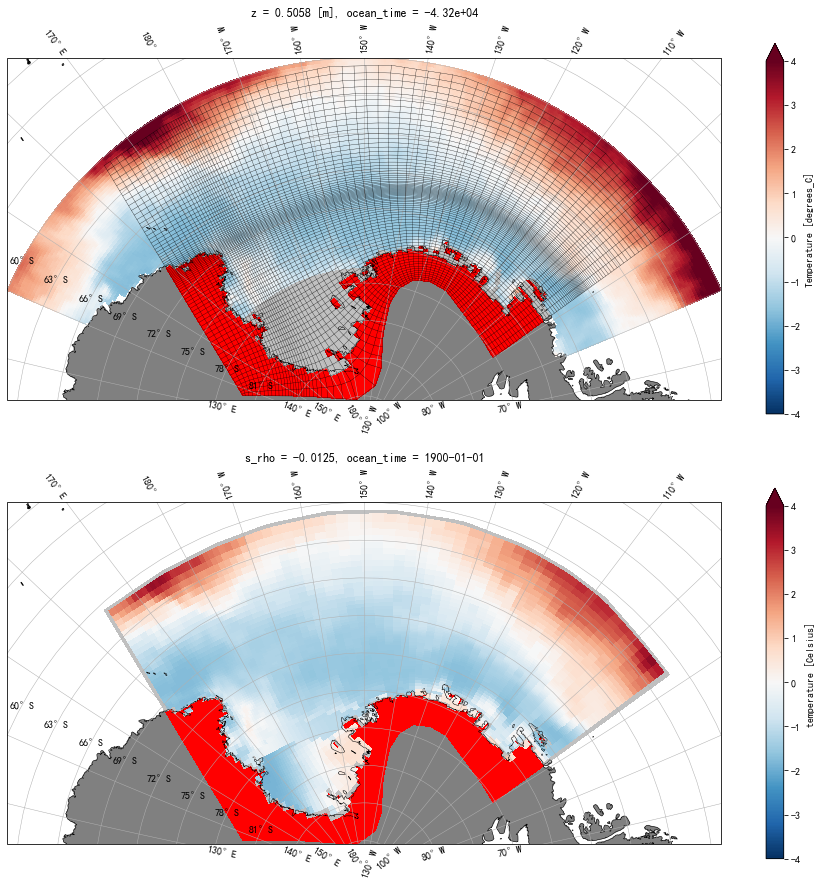

In [4]:
lon0, lat0 = 210., -75.
mproj = ccrs.Stereographic(
    central_latitude=lat0, central_longitude=lon0,
    false_easting=0.0, false_northing=0.0)

fig, ax = plt.subplots(2, 1, figsize=[16, 15], sharex=True,sharey=True, subplot_kw={'projection': mproj})
cmap = ListedColormap(['r', 'silver'])
for i in range(2):
    ax[i].gridlines(xlocs=range(-180, 180, 10), ylocs=range(-90, 90, 3),
                 linewidth=0.5, draw_labels=True)
    ax[i].coastlines(resolution='10m', linewidth=0.5)
    ax[i].add_feature(cfeature.LAND, facecolor='gray')
    ax[i].pcolormesh(grd.hgrid.x_vert, grd.hgrid.y_vert, grd.hgrid.mask_rho, cmap=cmap)

dsi.temp[0, 0].plot(x='x', y='y', ax=ax[0], vmin=-4, vmax=4, cmap='RdBu_r')
lines = ax[0].plot(grd.hgrid.x_vert, grd.hgrid.y_vert, 'k', lw=0.3)
lines = ax[0].plot(grd.hgrid.x_vert.T, grd.hgrid.y_vert.T, 'k', lw=0.3)
ds.temp[0, -1].plot(x='x_rho', y='y_rho', ax=ax[1], vmin=-4, vmax=4, cmap='RdBu_r')

In [ ]:
dsi = xr.open_dataset(data_file)
t, z, x, y = 'ocean_time', 'depth', 'longitude', 'latitude'
dsr, dsi, dso = pyroms.regrid.make_bry(dsi, grd,
                                       filename='../data/ras_bry.nc',
                                       t=t, z=z, x=x, y=y,
                                       is_dir=[True, True, False, True],
                                       flood=False, flood_raw=False)